Mengimport library dan modul yang dibutuhkan.

os : Untuk mengakses file dan direktori (misalnya, membaca folder dataset).

cv2 (OpenCV) : Digunakan untuk membaca, memproses, dan mengubah warna citra.

matplotlib.pyplot : Untuk menampilkan gambar atau grafik visual.

numpy : Untuk operasi matematis dan manipulasi array (karena citra adalah array).

pandas : Untuk mengelola dan menyajikan data dalam bentuk tabel (DataFrame).

seaborn :Untuk visualisasi data statistik.

ConfusionMatrixDisplay :Untuk menampilkan confusion matrix dalam bentuk visual (plot/heatmap).

from sklearn.model_selection import train_test_split, cross_val_predict : Untuk pisah data training/testing, validasi silang.

from sklearn.metrics import accuracy_score, classification_report : Untuk evaluasi model akurasi, presisi, recall, f1, dan visualisasi confusion matrix.

from skimage.feature import graycomatrix, graycoprops : Untuk ekstrak fitur tekstur dari gambar (GLCM).

from scipy.stats import entropy : Untuk hitung entropi (tingkat ketidakteraturan citra).

from sklearn.ensemble import RandomForestClassifier : Untuk model Random Forest.

from sklearn.svm import SVC : Untuk model SVM.

from sklearn.neighbors import KNeighborsClassifier : Untuk model K-Nearest Neighbor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report : Untuk accuracy_score untuk akurasi, precision_score untuk ketepatan prediksi positif, recall_score untuk sensitivitas, f1_score sebagai rata-rata presisi dan recall, confusion_matrix untuk matriks prediksi benar/salah, dan classification_report untuk ringkasan lengkap semua metrik.

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay) : Untuk  menghasilkan matriks yang menunjukkan jumlah prediksi benar dan salah antar kelas, dan untuk menampilkan matriks tersebut dalam bentuk grafik visual yang mudah dibaca.


In [24]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

Medium


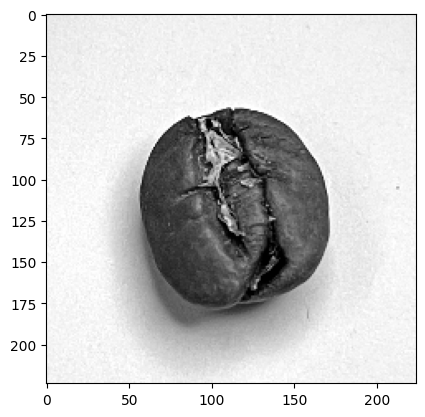

In [25]:
# data = []
# labels = []
# file_name = []
# for sub_folder in os.listdir("dataset\\"):
#     sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
#     for i, filename in enumerate(sub_folder_files):
#         img_path = os.path.join("dataset\\", sub_folder, filename)
#         img = cv.imread(img_path)
#         img = img.astype(np.uint8)
#         img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
#         data.append(img)
#         labels.append(sub_folder)
#         name = os.path.splitext(filename)[0]
#         file_name.append(filename)
        
# data = np.array(data)
# labels = np.array(labels)

data = []
labels = []
file_name = []

base_path = "dataset\\"

for sub_folder in os.listdir(base_path):
    sub_folder_path = os.path.join(base_path, sub_folder)
    
    if not os.path.isdir(sub_folder_path):
        continue  # Lewati jika bukan folder
    
    sub_folder_files = os.listdir(sub_folder_path)
    sub_folder_files = sub_folder_files[:100]  # Ambil hanya 100 file pertama

    for filename in sub_folder_files:
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        if img is None:
            continue  # Lewati file jika gagal dibaca

        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

plt.imshow(data[300],cmap='gray')
print(labels[300])

Program di atas digunakan untuk membaca gambar dari folder dataset, di mana setiap subfolder merepresentasikan satu label. Gambar dari masing-masing subfolder dibatasi hanya 100 file pertama, lalu dibaca menggunakan OpenCV, dikonversi ke grayscale, dan disimpan ke dalam list `data`. Label (nama folder) disimpan ke `labels`, dan nama file disimpan ke `file_name`. Setelah semua gambar diproses, list diubah menjadi array NumPy agar lebih efisien dipakai dalam pemrosesan. Terakhir, kode menampilkan salah satu gambar (`data[300]`) dan mencetak label-nya (`labels[300]`).


## Data Augmentation

### Define Augmentation Function


Program di bawah digunakan untuk membuat citra hasil flip (cermin) secara horizontal dan vertikal. Keduanya bekerja dengan cara membuat array kosong (result) berukuran sama dengan gambar asli, lalu menyalin piksel dari gambar input (img) ke posisi yang dicerminkan.

Pada fungsi mirror_h(img), proses flip dilakukan secara horizontal (kiri-kanan), di mana setiap piksel pada baris i dan kolom j akan diisi dengan nilai dari kolom di posisi sebaliknya (cols - j - 1). Sedangkan pada fungsi mirror_v(img), flip dilakukan secara vertikal (atas-bawah), dengan menyalin piksel dari baris rows - i - 1, sehingga citra seolah-olah dicerminkan terhadap sumbu horizontal.

In [26]:
def mirror_h(img):
    rows, cols = img.shape
    result = np.zeros_like(img)
    for i in range(rows):
        for j in range(cols):
            result[i, j] = img[i, cols - j - 1]
    return result

def mirror_v(img):
    rows, cols = img.shape
    result = np.zeros_like(img)
    for i in range(rows):
        for j in range(cols):
            result[i, j] = img[rows - i - 1, j]
    return result

Program di bawah digunakan untuk memutar gambar (img) sebesar sudut tertentu (angle_deg), dengan membuat hasil rotasi berada di tengah kanvas baru agar tidak terpotong. Pertama, sudut derajat dikonversi ke radian karena fungsi trigonometri di NumPy menggunakan radian. Lalu dihitung nilai cos dan sin untuk transformasi rotasi. Fungsi ini menentukan ukuran gambar baru (new_rows, new_cols) agar seluruh hasil rotasi muat, dan membuat gambar kosong (new_img) dengan ukuran tersebut. Titik tengah gambar lama dan baru dihitung agar rotasi berpusat.

Untuk setiap piksel pada gambar baru (new_img), posisi (i, j) diubah ke koordinat relatif terhadap pusat, kemudian dihitung posisi asalnya di gambar lama dengan rumus rotasi terbalik. Jika posisi asal tersebut masih berada dalam batas gambar asli, maka nilai piksel dari posisi asal disalin ke posisi baru. Ini dilakukan agar gambar terlihat seperti diputar tanpa kehilangan informasi.

In [27]:
def rotate_custom(img, angle_deg):
    angle_rad = np.radians(angle_deg)
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)

    rows, cols = img.shape
    cx, cy = rows / 2, cols / 2

    new_rows = int(abs(rows * cos_theta) + abs(cols * sin_theta))
    new_cols = int(abs(cols * cos_theta) + abs(rows * sin_theta))

    new_img = np.zeros((new_rows, new_cols), dtype=img.dtype)

    new_cx, new_cy = new_rows / 2, new_cols / 2

    for i in range(new_rows):
        for j in range(new_cols):
            # Translasi ke pusat
            y = i - new_cx
            x = j - new_cy

            # Rotasi balik
            orig_x = cos_theta * x + sin_theta * y + cx
            orig_y = -sin_theta * x + cos_theta * y + cy

            orig_x = int(round(orig_x))
            orig_y = int(round(orig_y))

            if 0 <= orig_x < rows and 0 <= orig_y < cols:
                new_img[i, j] = img[orig_x, orig_y]

    return new_img


Program di bawah digunakan untuk mengubah ukuran gambar dengan faktor skala `sx` (lebar) dan `sy` (tinggi). Gambar baru dibuat dengan ukuran yang disesuaikan, lalu setiap piksel di gambar baru diisi dengan nilai dari posisi yang sesuai di gambar asli, berdasarkan pembagian skala. Ini adalah bentuk scaling manual (nearest neighbor) yang sederhana.


In [28]:
def scale(img, sx, sy):
    rows, cols = img.shape
    new_rows = int(rows * sy)
    new_cols = int(cols * sx)
    result = np.zeros((new_rows, new_cols), dtype=img.dtype)
    for i in range(new_rows):
        for j in range(new_cols):
            orig_i = min(int(i / sy), rows - 1)
            orig_j = min(int(j / sx), cols - 1)
            result[i, j] = img[orig_i, orig_j]
    return result

Program di bawah melakukan augmentasi data citra dengan cara menyalin gambar asli dan membuat beberapa versi modifikasinya, lalu menyimpannya dalam list baru. Empat list kosong disiapkan: `data_augmented` untuk gambar, `labels_all` untuk label, `file_names_all` untuk nama file, dan `paths_all` untuk menyimpan path (di sini masih kosong). 

Perulangan `for i in range(len(data))` digunakan untuk mengambil setiap gambar asli satu per satu beserta label dan nama filenya. Di dalam loop, gambar asli langsung ditambahkan terlebih dahulu ke list hasil. Setelah itu, dibuat empat versi augmentasi menggunakan fungsi `mirror_h`, `mirror_v`, `rotate_custom`, dan `scale`. Gambar-gambar hasil augmentasi ini dikumpulkan dalam list `augmented_images`, lalu dilakukan loop lagi untuk menyimpan setiap gambar augmentasi ke list `data_augmented`, dengan label yang sama dan nama file yang diberi akhiran sesuai jenis augmentasinya. Jadi, satu gambar asli akan menghasilkan lima data total: 1 asli + 4 augmentasi.


In [29]:
# # melakukan augmentasi data
# data_augmented = []
# labels_augmented = []
# paths_augmented = []
# file_name_augmented = []
# for i in range(len(data)):
# 	pass

# data_augmented = []
# labels_augmented = []
# paths_augmented = []
# file_name_augmented = []

# for i in range(len(data)):
#     img = data[i]
#     label = labels[i]
#     fname = file_name[i]

#     # Augmentasi
#     img_flipped_h = mirror_h(img)
#     img_flipped_v = mirror_v(img)
#     img_rotated = rotate_custom(img, 45)
#     img_scaled  = scale(img, 2, 2)

#     augmented_images = [
#         (img_flipped_h, '_flip_h'),
#         (img_flipped_v, '_flip_v'),
#         (img_rotated, '_rot'),
#         (img_scaled, '_scale')
#     ]

#     for aug_img, suffix in augmented_images:
#         data_augmented.append(aug_img)
#         labels_augmented.append(label)
#         file_name_augmented.append(fname + suffix)
#         paths_augmented.append("")  # tambahkan path jika perlu

# # Gabungkan data asli dan data augmentasi (hati-hati dengan ukuran yang berbeda)
# data_all = list(data) + data_augmented
# labels_all = list(labels) + labels_augmented
# file_names_all = list(file_name) + file_name_augmented

data_augmented = []
labels_all = []
file_names_all = []
paths_all = []

for i in range(len(data)):
    img = data[i]
    label = labels[i]
    fname = file_name[i]

    # Tambahkan data asli terlebih dahulu
    data_augmented.append(img)
    labels_all.append(label)
    file_names_all.append(fname)
    paths_all.append("")

    # Augmentasi
    img_flipped_h = mirror_h(img)
    img_flipped_v = mirror_v(img)
    img_rotated = rotate_custom(img, 45)
    img_scaled  = scale(img, 2, 2)

    augmented_images = [
        (img_flipped_h, '_flip_h'),
        (img_flipped_v, '_flip_v'),
        (img_rotated, '_rot'),
        (img_scaled, '_scale')
    ]

    for aug_img, suffix in augmented_images:
        data_augmented.append(aug_img)
        labels_all.append(label)
        file_names_all.append(fname + suffix)
        paths_all.append("")




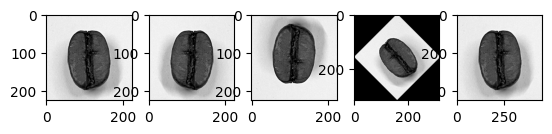

In [30]:
plt.subplot(1,5,1)
plt.imshow(data_augmented[0],cmap='gray')
plt.subplot(1,5,2)
plt.imshow(data_augmented[1],cmap='gray')
plt.subplot(1,5,3)
plt.imshow(data_augmented[2],cmap='gray')
plt.subplot(1,5,4)
plt.imshow(data_augmented[3],cmap='gray')
plt.subplot(1,5,5)
plt.imshow(data_augmented[4],cmap='gray')

Program di atas untuk menampilkan 5 citra hasil augmentasi 
data_augmented[0] → gambar asli

data_augmented[1] → gambar hasil flip horizontal

data_augmented[2] → gambar hasil flip vertikal

data_augmented[3] → gambar hasil rotasi

data_augmented[4] → gambar hasil scaling

Program di bawah untuk menampilkan jumlah data gambar sebelum dan sesudah augmentasi

In [31]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  400
Data setelah augmentasi:  2000


## Data Preparation

### Define Preprocessing Function


Program di bawah digunakan untuk meningkatkan kontras gambar grayscale melalui proses histogram equalization secara manual. Fungsi ini pertama-tama menghitung histogram piksel (jumlah kemunculan tiap intensitas 0–255), lalu menghitung PDF (probabilitas) dan CDF (distribusi kumulatif) dari intensitas tersebut. Berdasarkan CDF, dibuat pemetaan nilai piksel baru agar distribusinya lebih merata. Terakhir, fungsi menerapkan pemetaan tersebut ke seluruh piksel gambar dan menghasilkan gambar baru dengan kontras yang ditingkatkan.


In [32]:
def equalize_histogram2(image):
    height, width = image.shape

    histogram = [0] * 256
    for i in range(height):
        for j in range(width):
            histogram[int(image[i][j])] += 1

    total_pixels = height * width
    pdf = [h / total_pixels for h in histogram]

    cdf = [0] * 256
    cdf[0] = pdf[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + pdf[i]

    mapping = [int(round(c * 255)) for c in cdf]

    result = np.zeros((height, width), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            result[i][j] = mapping[int(image[i][j])]

    return result


Program di bawah digunakan untuk menyesuaikan histogram gambar input (`imgInput`) agar **menyerupai histogram gambar target** (`imgTarget`) secara manual. Pertama, fungsi menghitung histogram dan CDF (cumulative distribution function) dari kedua gambar. Lalu, untuk setiap nilai intensitas di gambar input, fungsi mencari nilai intensitas pada target yang memiliki nilai CDF paling mendekati, dan membuat **mapping** antara keduanya. Setelah mapping selesai, nilai intensitas gambar input diubah sesuai mapping tersebut, lalu dibentuk kembali menjadi gambar dengan bentuk aslinya. Hasil akhirnya adalah gambar input yang memiliki distribusi intensitas piksel serupa dengan gambar target.


In [33]:
def manual_histogram_matching(imgInput, imgTarget):
    src_hist = [0] * 256
    ref_hist = [0] * 256
    
    for pixel in imgInput.flatten():
        src_hist[pixel] += 1
    
    for pixel in imgTarget.flatten():
        ref_hist[pixel] += 1

    src_cdf = [0.0] * 256
    ref_cdf = [0.0] * 256

    total_src = sum(src_hist)
    total_ref = sum(ref_hist)

    cumsum_src = 0
    cumsum_ref = 0
    for i in range(256):
        cumsum_src += src_hist[i]
        cumsum_ref += ref_hist[i]
        src_cdf[i] = cumsum_src / total_src
        ref_cdf[i] = cumsum_ref / total_ref

    mapping = [0] * 256
    for src_val in range(256):
        min_diff = 1.0
        closest_val = 0
        for ref_val in range(256):
            diff = abs(src_cdf[src_val] - ref_cdf[ref_val])
            if diff < min_diff:
                min_diff = diff
                closest_val = ref_val
        mapping[src_val] = closest_val

    flat_input = imgInput.flatten()
    matched_flat = np.array([mapping[pixel] for pixel in flat_input], dtype=np.uint8)
    matched_image = matched_flat.reshape(imgInput.shape)

    return matched_image


Fungsi resixe_image melakukan resize (ubah ukuran) gambar ke dimensi yang diinginkan (target_height, target_width) secara manual. Skala perbandingan ukuran asli dan target dihitung, lalu setiap piksel pada gambar baru diisi dengan piksel dari posisi yang sesuai di gambar asli berdasarkan skala. Ini menggunakan metode nearest neighbor.

Fungsi prepo1 hanya mengembalikan gambar asli tanpa perubahan. Baris konversi ke grayscale (cv.cvtColor) dikomentari, jadi saat ini fungsi ini tidak melakukan apa pun—biasanya digunakan sebagai placeholder atau tahapan pertama.

Fungsi prepo2 melakukan histogram equalization pada gambar menggunakan fungsi equalize_histogram2, untuk meningkatkan kontras gambar dengan menyebarkan intensitas piksel secara merata.

Fungsi prepo 3 ini melakukan histogram matching, yaitu menyesuaikan tampilan intensitas gambar (img) agar mirip dengan gambar acuan (img_spec), menggunakan fungsi manual_histogram_matching.



In [34]:
def convo(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    result = np.zeros_like(image).astype(np.float32)

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result

kernel_mean_tanpa_mesin = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
])

In [35]:
def resize_image(img, target_height, target_width):
    img = np.array(img)
    height, width = img.shape

    resized_img = np.zeros((target_height, target_width), dtype=img.dtype)

    scale_x = target_width / width
    scale_y = target_height / height

    for i in range(target_height):
        for j in range(target_width):
            orig_x = int(j / scale_x)
            orig_y = int(i / scale_y)
            orig_x = min(orig_x, width - 1)
            orig_y = min(orig_y, height - 1)

            resized_img[i, j] = img[orig_y, orig_x]

    return resized_img


def prepro1(img):
    img = convo(img,kernel_mean_tanpa_mesin)
    return img

def prepro2(img):
    hist = equalize_histogram2(img)
    return hist

def prepro3(img,img_spec):
    spec = manual_histogram_matching(img,img_spec)
    return spec
    


### Preprocessing

In [ ]:
# # pada bagian ini bisa gunakan data_augmented yang sebelum augmentasi atau setelah augmentasi
# dataPreprocessed = []
# for i in range(len(data)): # Loop through each image and do preprocessing
# 	pass

dataPreprocessed = []
target_size=128
target_height, target_width = 128,128  # ukuran gambar yang diinginkan (misal 128x128)

for i in range(len(data_augmented)):
    img = data_augmented[i]

    # Resize gambar ke target_size x target_size
    img_resized = resize_image(img, target_height,target_width)

    # Preprocessing: normalisasi intensitas (misal fungsi prepro1)
    img_1 = prepro1(img_resized)
    img_2 = prepro2(img_1)
    if i in [495,496,497,498,499,995,996,997,998,999,1495,1496,1497,1498,1499,1995,1996,1997,1998,1999]:
        img_spec = data_augmented[i-5]
    else : 
        img_spec = data_augmented[i+5]
    img_3 = prepro3(img_2,img_spec)

    dataPreprocessed.append(img_3)

plt.imshow(dataPreprocessed[0],cmap='gray')


Program di atas ini memproses setiap gambar dalam `data_augmented` dengan tiga tahap: resize ke 128x128 piksel, histogram equalization untuk meningkatkan kontras, dan histogram matching agar intensitasnya menyerupai gambar referensi. Gambar referensi dipilih dari gambar sebelum atau sesudahnya tergantung posisi indeks. Hasil akhirnya disimpan ke `dataPreprocessed` dan ditampilkan salah satu contohnya.


### Feature Extraction

Program di bawah digunakan untuk menghitung Gray Level Co-occurrence Matrix (GLCM) dari sebuah gambar grayscale dengan sudut tertentu. Fungsi ini menerima gambar dan sudut (`derajat`) yang bisa bernilai 0, 45, 90, atau 135 derajat, lalu mengubahnya ke radian (karena GLCM di `graycomatrix` memakai satuan radian). Setelah gambar dipastikan bertipe `uint8`, fungsi menghitung GLCM dengan jarak piksel 1, simetris, dan ternormalisasi, lalu mengembalikannya sebagai matriks GLCM. GLCM ini akan digunakan untuk ekstraksi fitur tekstur seperti contrast, homogeneity, energy, dan lainnya.


In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

   
    image = image.astype(np.uint8)

    glcm_matrix = graycomatrix(image, distances=[1], angles=angles, levels=256, symmetric=True, normed=True)
    return glcm_matrix


Fungsi di bawah untuk menghitung nilai korelasi dari GLCM, yaitu seberapa kuat hubungan antar piksel dalam gambar. Nilainya diambil dari hasil graycoprops(matriks, 'correlation') pada indeks [0, 0].

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi di bawah digunakan untuk menghitung tingkat perbedaan antar piksel dalam GLCM. Semakin tinggi nilainya, semakin besar perbedaan intensitas antar piksel di gambar. Nilai diambil dari hasil `graycoprops` dan dikembalikan sebagai satu angka.


In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi di bawah menghitung tingkat keseragaman tekstur dari GLCM. Nilai yang tinggi menunjukkan bahwa piksel-piksel memiliki intensitas yang mirip atau berdekatan. Hasilnya diambil dari `graycoprops` dan dikembalikan sebagai satu nilai.


In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi di bawah digunakan untuk menghitung kontras tekstur dari GLCM. Nilai kontras menunjukkan seberapa besar perbedaan intensitas antar piksel; makin tinggi nilainya, makin tajam perbedaan intensitasnya. Hasilnya dikembalikan sebagai satu angka dari `graycoprops`.


In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi di bawah digunakan untuk menghitung Angular Second Moment dari GLCM, yang juga dikenal sebagai energy. Nilai ini menunjukkan tingkat keteraturan tekstur — semakin tinggi nilainya, semakin seragam atau halus teksturnya. Nilai dikembalikan sebagai satu angka dari `graycoprops`.


In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi di bawah digunakan untuk menghitung energi tekstur dari GLCM, yang mencerminkan keteraturan atau kekompakan dalam distribusi intensitas piksel. Nilai energy merupakan akar kuadrat dari ASM, dan makin tinggi nilainya, makin halus atau teratur teksturnya. Hasilnya dikembalikan sebagai satu nilai dari `graycoprops`.


In [ ]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi di bawah digunakan untuk menghitung entropi dari GLCM, yaitu seberapa **acak atau kompleks** tekstur gambar. Makin tinggi nilainya, makin tidak teratur teksturnya.


In [ ]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

 Program di bawah digunakan untuk menghitung GLCM dari setiap gambar di `dataPreprocessed` pada 4 sudut berbeda: 0°, 45°, 90°, dan 135°. Untuk setiap gambar, fungsi `glcm()` dipanggil 4 kali (masing-masing untuk satu sudut), dan hasilnya disimpan ke dalam list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Dengan begitu, tiap list akan berisi matriks GLCM untuk seluruh gambar pada sudut tertentu, yang nantinya bisa digunakan untuk ekstraksi fitur tekstur.


In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

MemoryError: Unable to allocate 512. KiB for an array with shape (256, 256, 1, 1) and data type float64

Program di bawah untuk menyiapkan list kosong untuk menyimpan hasil ekstraksi tujuh jenis fitur tekstur dari GLCM, yaitu kontras, dissimilarity, homogenity, entropy, ASM, energy, dan correlation. Setiap fitur akan dihitung untuk empat sudut arah GLCM: 0°, 45°, 90°, dan 135°, sehingga total ada 28 list yang masing-masing akan diisi nilai fitur dari seluruh gambar. List ini digunakan untuk menyimpan hasil ekstraksi agar bisa dianalisis atau digunakan sebagai input model klasifikasi.

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Program di bawah digunakan untuk menghitung nilai korelasi (correlation) dari matriks GLCM pada masing-masing sudut (0°, 45°, 90°, 135°) untuk setiap gambar dalam `dataPreprocessed`. Di setiap iterasi, fungsi `correlation()` dipanggil dengan GLCM yang sesuai (`Derajat0[i]`, `Derajat45[i]`, dst.), dan hasilnya disimpan ke list `correlation0`, `correlation45`, `correlation90`, dan `correlation135`. Tujuannya adalah untuk mengisi list-list tersebut dengan nilai korelasi sebagai bagian dari fitur tekstur yang akan digunakan untuk analisis atau klasifikasi.


In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    C45 = correlation(Derajat45[i])
    C90 = correlation(Derajat90[i])
    C135 = correlation(Derajat135[i])
    correlation0.append(C0) 
    
    correlation45.append(C45)
    
    correlation90.append(C90)
    
    correlation135.append(C135)

Program di bawah digunakan untuk menghitung nilai kontras (contrast) dari matriks GLCM pada masing-masing sudut (0°, 45°, 90°, 135°) untuk setiap gambar dalam `dataPreprocessed`. Di setiap iterasi, fungsi `contrast()` dipanggil dengan GLCM yang sesuai (`Derajat0[i]`, `Derajat45[i]`, dst.), dan hasilnya disimpan ke list `contrast0`, `contrast45`, `contrast90`, dan `contrast135`. Tujuannya adalah untuk mengambil nilai kontras sebagai fitur tekstur dari setiap gambar pada empat sudut GLCM. Nilai kontras ini penting karena mengukur seberapa besar perbedaan intensitas antara piksel-piksel yang berdekatan—semakin tinggi nilainya, semakin tajam atau mencolok teksturnya.


In [ ]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Program di bawah digunakan untuk menghitung nilai dissimilarity dari matriks GLCM pada masing-masing sudut (0°, 45°, 90°, 135°) untuk setiap gambar dalam `dataPreprocessed`. Di setiap iterasi, fungsi `dissimilarity()` dipanggil dengan GLCM yang sesuai (`Derajat0[i]`, `Derajat45[i]`, dst.), dan hasilnya disimpan ke list `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`. Tujuannya adalah untuk mengambil nilai dissimilarity sebagai fitur tekstur dari setiap gambar pada empat sudut GLCM. Nilai ini penting karena dissimilarity mengukur seberapa besar perbedaan intensitas antar piksel, semakin tinggi nilainya, semakin kasar atau bervariasi teksturnya.

In [ ]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Program di bawah digunakan untuk menghitung nilai homogenity dari matriks GLCM pada masing-masing sudut (0°, 45°, 90°, 135°) untuk setiap gambar dalam `dataPreprocessed`. Di setiap iterasi, fungsi `homogenity()` dipanggil dengan GLCM yang sesuai (`Derajat0[i]`, `Derajat45[i]`, dst.), dan hasilnya disimpan ke list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Tujuannya adalah untuk mengambil nilai homogenity sebagai fitur tekstur dari setiap gambar pada empat sudut GLCM. Nilai ini diambil karena homogenity mengukur tingkat keseragaman dalam gambar, semakin tinggi nilainya, semakin halus dan seragam teksturnya

In [ ]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Program di bawah digunakan untuk menghitung nilai entropyGlcm dari matriks GLCM pada masing-masing sudut (0°, 45°, 90°, 135°) untuk setiap gambar dalam `dataPreprocessed`. Di setiap iterasi, fungsi `entropyGlcm()` dipanggil dengan GLCM yang sesuai (`Derajat0[i]`, `Derajat45[i]`, dst.), dan hasilnya disimpan ke list `entropyGlcm0`, `entropyGlcm45`, `entropyGlcm90`, dan `entropyGlcm135`. Tujuannya adalah untuk mengambil nilai entropi sebagai fitur tekstur dari setiap gambar pada empat sudut GLCM. Nilai entropi penting karena mengukur tingkat keacakan atau kompleksitas pola tekstur dalam gambar, semakin tinggi entropi, semakin tidak teratur teksturnya. 

In [ ]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Program di bawah digunakan untuk menghitung nilai ASM dari matriks GLCM pada masing-masing sudut (0°, 45°, 90°, 135°) untuk setiap gambar dalam `dataPreprocessed`. Di setiap iterasi, fungsi `ASM()` dipanggil dengan GLCM yang sesuai (`Derajat0[i]`, `Derajat45[i]`, dst.), dan hasilnya disimpan ke list `ASM0`, `ASM45`, `ASM90`, dan `ASM135`. Tujuannya adalah untuk mengambil nilai ASM (Angular Second Moment) sebagai fitur tekstur dari setiap gambar pada empat sudut GLCM. ASM penting karena mengukur tingkat keteraturan atau kekompakan tekstur—nilai tinggi menunjukkan tekstur yang lebih seragam dan teratur.

In [ ]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Program di bawah digunakan untuk menghitung nilai energy dari matriks GLCM pada masing-masing sudut (0°, 45°, 90°, 135°) untuk setiap gambar dalam `dataPreprocessed`. Di setiap iterasi, fungsi `energy()` dipanggil dengan GLCM yang sesuai (`Derajat0[i]`, `Derajat45[i]`, dst.), dan hasilnya disimpan ke list `energy0`, `energy45`, `energy90`, dan `energy135`. Tujuannya adalah untuk mengambil nilai energy sebagai fitur tekstur dari setiap gambar pada empat sudut GLCM. Nilai energy menunjukkan tingkat kekompakan atau keseragaman tekstur, yang merupakan akar kuadrat dari ASM. 

In [ ]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

Program di bawah ini menyusun semua fitur tekstur yang telah diekstrak—seperti contrast, homogeneity, dissimilarity, entropy, ASM, energy, dan correlation dari empat sudut GLCM—beserta nama file dan labelnya ke dalam sebuah dictionary bernama `dataTable`. Selanjutnya, kode mencetak panjang setiap kolom untuk memastikan jumlah datanya konsisten, lalu mengonversi dictionary tersebut menjadi DataFrame menggunakan pandas dan menyimpannya ke file CSV bernama `hasil_ekstraksi_2.csv`. Terakhir, kode juga membaca file CSV lain bernama `hasil_ekstraksi_1.csv` ke dalam DataFrame untuk keperluan analisis atau pelatihan model lebih lanjut.

In [ ]:
dataTable = {'Filename': file_names_all, 'Label': labels_all,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
for key, value in dataTable.items():
    print(f"{key}: length = {len(value)}")


df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')


NameError: name 'Kontras0' is not defined

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

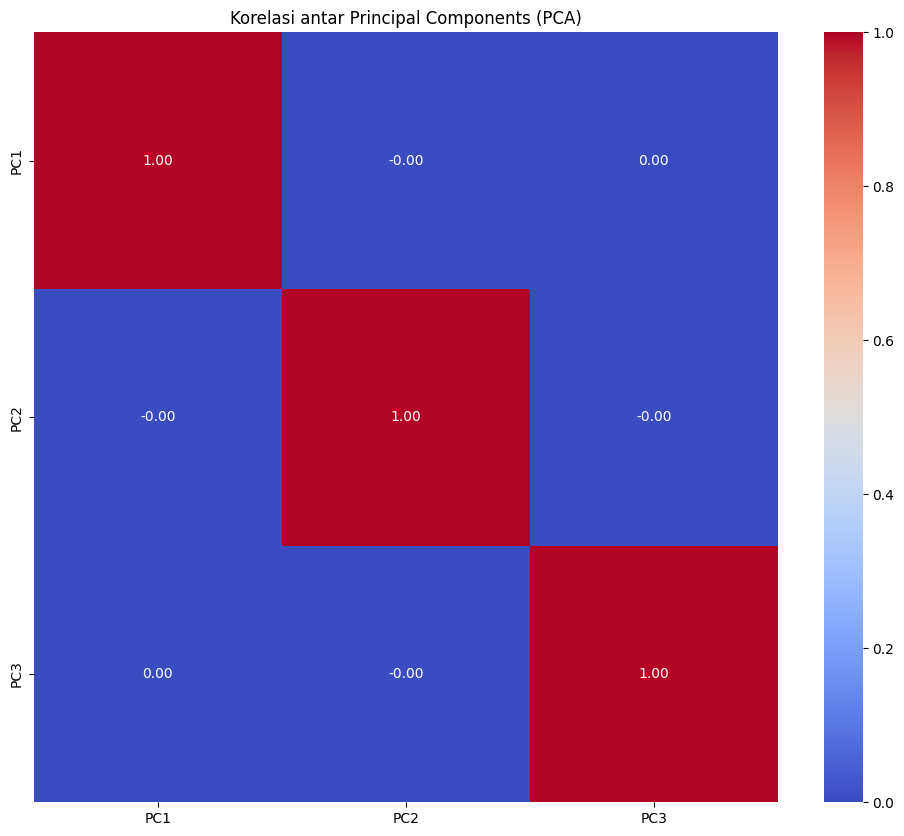

Proporsi Variansi Tiap Komponen PCA:
PC1: 0.6101 (61.01%)
PC2: 0.2899 (28.99%)
PC3: 0.0683 (6.83%)


In [ ]:
# # Menghitung korelasi
# correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# # Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
# threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
# selectionFeature = []
# columns = np.full((correlation.shape[0],), True, dtype=bool)
# for i in range(correlation.shape[0]):
# 	for j in range(i+1, correlation.shape[0]):
# 		if correlation.iloc[i,j] >= threshold:
# 			if columns[j]:
# 				columns[j] = False
# select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
# x_new = hasilEkstrak[select]
# y = hasilEkstrak['Label']
# plt.figure(figsize=(17,17))
# sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Ambil fitur saja (hapus Label dan Filename)
X = hasilEkstrak.drop(columns=['Label', 'Filename'])

# 2. Standardisasi data (PCA sensitif terhadap skala fitur)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Terapkan PCA (misalnya ambil 95% variansi)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# 4. Buat DataFrame baru dari hasil PCA
x_new = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
y = hasilEkstrak['Label']

# 5. Visualisasi Heatmap korelasi antar Principal Components
plt.figure(figsize=(12, 10))
sns.heatmap(x_new.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi antar Principal Components (PCA)')
plt.show()

# 6. (Opsional) Tampilkan variansi tiap komponen
explained_variance = pca.explained_variance_ratio_
print("Proporsi Variansi Tiap Komponen PCA:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")

#LDA

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.preprocessing import StandardScaler

# # 1. Pisahkan fitur dan label
# X = hasilEkstrak.drop(columns=['Label', 'Filename'])
# y = hasilEkstrak['Label']

# # 2. Standardisasi fitur (direkomendasikan)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 3. Terapkan LDA
# # n_components maksimal = jumlah kelas - 1
# lda = LDA(n_components=None)  # akan mengambil semua komponen yang mungkin
# X_lda = lda.fit_transform(X_scaled, y)

# # 4. Buat DataFrame hasil LDA
# x_new = pd.DataFrame(X_lda, columns=[f'LD{i+1}' for i in range(X_lda.shape[1])])

# # 5. Visualisasi hasil LDA (misal plot 2 komponen pertama jika ada)
# if x_new.shape[1] >= 2:
#     plt.figure(figsize=(10, 8))
#     for label in np.unique(y):
#         plt.scatter(
#             x_new[y == label].iloc[:, 0],
#             x_new[y == label].iloc[:, 1],
#             label=f'Class {label}',
#             alpha=0.7
#         )
#     plt.xlabel('LD1')
#     plt.ylabel('LD2')
#     plt.title('Proyeksi Hasil LDA')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # 6. (Opsional) Tampilkan heatmap korelasi antar LD
# plt.figure(figsize=(10, 8))
# sns.heatmap(x_new.corr(), annot=True, cmap='viridis', fmt='.2f')
# plt.title("Korelasi antar Linear Discriminants")
# plt.show()

# from sklearn.feature_selection import mutual_info_classif, SelectKBest

# X = hasilEkstrak.drop(columns=['Label', 'Filename'])
# y = hasilEkstrak['Label']

# selector = SelectKBest(score_func=mutual_info_classif, k=10)  # pilih top 10 fitur
# X_selected = selector.fit_transform(X, y)

# # Lihat fitur yang terpilih
# selected_features = X.columns[selector.get_support()]
# print("Fitur terpilih:", selected_features)


Program di atas digunakan untuk menyederhanakan data fitur menggunakan PCA (Principal Component Analysis) agar tetap informatif namun lebih ringkas. Pertama, fitur numerik dipisahkan dari kolom `Label` dan `Filename`, lalu distandardisasi karena PCA sensitif terhadap skala. PCA diterapkan untuk mengambil komponen utama yang mewakili 95% variasi data. Hasilnya disimpan sebagai DataFrame baru berisi PC1, PC2, dan seterusnya. Untuk memastikan komponen saling independen, ditampilkan heatmap korelasi antar komponen. Terakhir, proporsi variansi tiap komponen dicetak untuk menunjukkan seberapa besar informasi yang dibawa oleh masing-masing PC.


## Splitting Data

Program di atas digunakan untuk membagi data hasil PCA menjadi data latih (`X_train`, `y_train`) dan data uji (`X_test`, `y_test`) dengan proporsi 70% untuk pelatihan dan 30% untuk pengujian, menggunakan fungsi `train_test_split` dari sklearn. Parameter `random_state=42` digunakan agar pembagian data bersifat konsisten saat kode dijalankan berulang. Fungsi `print()` digunakan untuk menampilkan jumlah data pada masing-masing bagian, sehingga kita bisa memastikan pembagian data berjalan dengan benar.


In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1400, 3)
(600, 3)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

program di atas digunakan untuk melakukan normalisasi Min-Max pada data latih dan data uji, agar semua fitur berada dalam rentang 0 hingga 1. Pertama, dicari nilai minimum dan maksimum dari `X_train`, lalu digunakan untuk menskalakan `X_train` dan `X_test` menggunakan rumus `(X - min) / (max - min)`. Proses ini penting agar setiap fitur memiliki skala yang seragam, sehingga model machine learning tidak bias terhadap fitur dengan nilai yang lebih besar.


In [ ]:
# # normalisasi mean std
# X_test = (X_test - X_train.mean()) / X_train.std()
# X_train = (X_train - X_train.mean()) / X_train.std()
# Hitung min dan max dari X_train
X_min = X_train.min()
X_max = X_train.max()

# Terapkan Min-Max Scaling pada X_train dan X_test
X_train_scaled = (X_train - X_min) / (X_max - X_min)
X_test_scaled = (X_test - X_min) / (X_max - X_min)


## Modeling

### Define Model

Program di atas digunakan untuk menampilkan hasil evaluasi model klasifikasi, termasuk classification report, confusion matrix, dan accuracy. Kemudian, tiga model klasifikasi didefinisikan:

RandomForestClassifier dengan 5 pohon keputusan (estimators) dan seed acak 42,

SVC (Support Vector Machine) dengan kernel radial basis function (RBF),

KNeighborsClassifier dengan 5 tetangga terdekat.

Ketiganya akan digunakan untuk melatih model dan mengevaluasi performanya terhadap data uji

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

        Dark       0.99      0.98      0.98       343
       Green       0.98      0.99      0.99       355
       Light       0.99      0.98      0.99       362
      Medium       0.98      0.99      0.98       340

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.99      0.98      0.99      1400

[[336   0   0   7]
 [  0 352   3   0]
 [  0   6 356   0]
 [  5   0   0 335]]
Accuracy: 0.985

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.83      0.89      0.86       157
       Green       0.90      0.91      0.90       145
       Light       0.83      0.84      0.84       138
      Medium       0.86      0.78      0.82       160

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.8

Program di atas untuk melatih model Random Forest menggunakan data latih `X_train` dan `y_train`, lalu mengevaluasi performanya pada data latih dan data uji. Setelah pelatihan, model memprediksi label pada `X_train` dan `X_test`, kemudian hasilnya dievaluasi menggunakan fungsi `generateClassificationReport` yang menampilkan classification report, confusion matrix, dan akurasi. Tujuannya adalah untuk melihat seberapa baik model mengenali pola pada data yang dipelajari dan mengujinya pada data baru.

Outputnya memperlihatkan bahwa model bekerja sangat baik pada data latih, dan cukup baik pada data uji, dengan akurasi 85.3%.

### Train SVM Classifier

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        Dark       0.65      0.68      0.66       343
       Green       0.80      0.90      0.85       355
       Light       0.76      0.65      0.70       362
      Medium       0.57      0.56      0.57       340

    accuracy                           0.70      1400
   macro avg       0.70      0.70      0.70      1400
weighted avg       0.70      0.70      0.70      1400

[[232   0   1 110]
 [  0 319  36   0]
 [ 15  79 236  32]
 [111   0  37 192]]
Accuracy: 0.6992857142857143

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.63      0.66      0.64       157
       Green       0.78      0.88      0.83       145
       Light       0.78      0.65      0.71       138
      Medium       0.61      0.59      0.60       160

    accuracy                           0.69       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.69     

Program di atas untuk melatih model SVM (Support Vector Machine) menggunakan data latih `X_train` dan `y_train`, lalu mengevaluasi performanya pada data latih dan data uji. Setelah model dilatih, prediksi dilakukan terhadap `X_train` dan `X_test`, lalu hasilnya dievaluasi menggunakan `generateClassificationReport` untuk menampilkan classification report, confusion matrix, dan akurasi. Evaluasi ini bertujuan untuk mengetahui kemampuan model dalam mengenali pola pada data pelatihan serta menguji generalisasi model terhadap data baru.

Model SVM mampu mengenali pola dasar dengan performanya akurasi sekitar 69%.


### Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

        Dark       0.89      0.92      0.90       343
       Green       0.95      0.94      0.94       355
       Light       0.92      0.91      0.91       362
      Medium       0.88      0.87      0.88       340

    accuracy                           0.91      1400
   macro avg       0.91      0.91      0.91      1400
weighted avg       0.91      0.91      0.91      1400

[[315   0   1  27]
 [  0 335  20   0]
 [  2  19 328  13]
 [ 38   0   6 296]]
Accuracy: 0.91

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.72      0.77      0.74       157
       Green       0.92      0.83      0.87       145
       Light       0.78      0.80      0.79       138
      Medium       0.68      0.68      0.68       160

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.7

Program di atas digunakan untuk melatih dan mengevaluasi model K-Nearest Neighbors (KNN). Pertama, model KNN dilatih menggunakan data latih `X_train` dan `y_train` dengan `knn.fit()`. Setelah itu, model digunakan untuk memprediksi data latih dan data uji. Hasil prediksi dievaluasi menggunakan fungsi `generateClassificationReport`, yang akan menampilkan classification report (precision, recall, dan F1-score), confusion matrix, dan akurasi. Tujuan dari proses ini adalah untuk menilai seberapa baik model KNN mengenali pola dari data latih dan seberapa akurat kinerjanya saat menghadapi data baru.

Model KNN menunjukkan performa yang baik dengan akurasi tinggi pada data latih dan cukup baik pada data uji. Meski ada penurunan performa (dari 91% ke 76.7%),


## Evaluation With Confusion Matrix

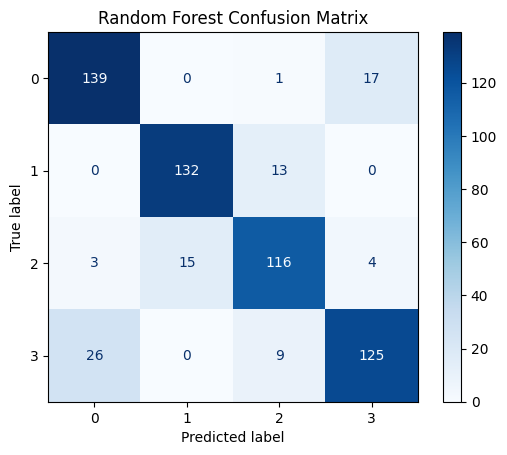

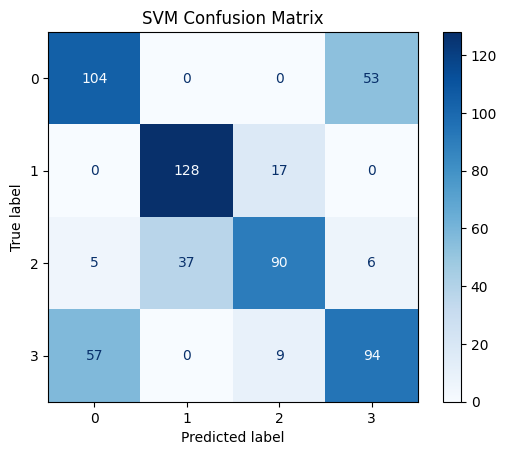

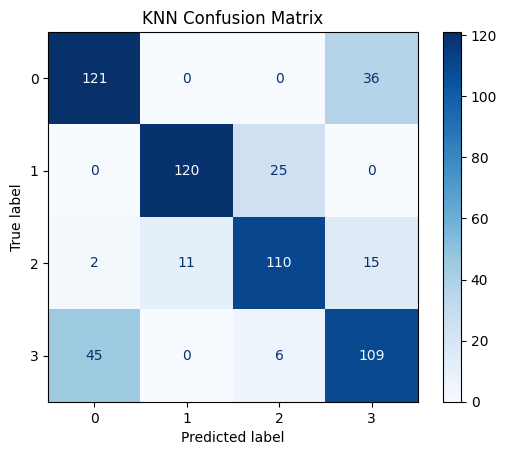

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

Program di atas digunakan untuk menampilkan confusion matrix dari tiga model klasifikasi: Random Forest, SVM, dan KNN. Fungsi `plot_confusion_matrix()` menerima label sebenarnya (`y_true`), hasil prediksi (`y_pred`), dan judul plot, lalu membuat confusion matrix menggunakan `ConfusionMatrixDisplay` dari sklearn dan menampilkannya sebagai grafik berwarna biru (`Blues colormap`). Kemudian, fungsi ini dipanggil tiga kali untuk menampilkan confusion matrix dari masing-masing model berdasarkan hasil prediksi pada data uji (`X_test`). Tujuannya adalah untuk membandingkan pola kesalahan klasifikasi antar model secara visual, agar lebih mudah melihat di kelas mana model paling sering salah atau benar dalam prediksi.
